In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from tqdm import tqdm
from scipy.linalg import eigvals
from scipy.stats import laplace
from scipy.stats import multivariate_normal
from scipy.special import expit
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

### 1. Introduction to **Stochastic Gradient Langevin Dynamics (SGLD)** for **Bayesian Logistic Regression**

In this notebook, we apply the **Stochastic Gradient Langevin Dynamics (SGLD)** method to perform **Bayesian Logistic Regression** with a **Laplace prior** of scale $b=1$. We also compare the performance of SGLD with other sampling methods to test its effectiveness, especially its speed.

This notebook is based on the paper **Bayesian Learning via Stochastic Gradient Langevin Dynamics** by Welling and Teh (2011). The goal is to detail the key steps of SGLD, with concrete examples to illustrate its workings.

### 2. Model for **Bayesian Logistic Regression**

The model for Bayesian Logistic Regression is as follows:

- Let $D = \{(x_1, y_1), ..., (x_N, y_N)\}$ be the dataset and $\beta$ the parameter,

- The prior is $p(\beta) \sim \mathcal{L}(0, 1)$, i.e., $p(\beta) \propto \exp(-\|\beta\|_1)$,

- For all $i \in \{1, ..., N\}$, $y_i \sim \mathcal{B}\left(\sigma(\beta^{\top}x_i)\right)$ i.i.d., where $\sigma$ is the sigmoid function. Using the property that $\forall z \in \mathbb{R}, \sigma(-z) = 1 - \sigma(z)$, we can write: $\forall i \in \{1, ..., N\}, p(y_i | \beta, x_i) = \sigma(y_i \cdot \beta^{\top}x_i)$.

The log posterior then becomes:

$$
\log p(\beta | X, y) \propto \sum_{i=1}^N \log \sigma(y_i \cdot \beta^{\top}x_i) - \|\beta\|_1
$$

We can then write a subgradient of the log-posterior using the fact that $\forall z \in \mathbb{R}, \sigma'(z) = (1 - \sigma(z)) \cdot \sigma(z)$, and the subgradient of the log-prior is $\partial_{\beta} \log p(\beta) = - \text{sign}(\beta)$:

$$
\partial_{\beta} \log p(\beta | X, y) = \sum_{i=1}^N y_i \cdot x_i \left( 1 - \sigma(y_i \cdot \beta^{\top}x_i) \right) - \text{sign}(\beta)
$$


## 1. Stochastic Gradient Langevin Dynamic

This method aims to combine **optimization** (SGD) and **sampling** (Langevin) into **a single method** to extend Bayesian methods to large datasets.

Its main strength (but also its weakness, which we will address...) is that it allows sampling in the manner of a Robbins-Monro method without having to compute over the entire dataset. **SGLD** uses data in **batches**, unlike most **MCMC** methods which use the **entire training set**.

For example, a symmetric random walk requires, at each iteration, the calculation of the acceptance probability of the candidate, which is a density ratio ($\alpha = \mathrm{min}(1, \pi(\theta_t) \, / \, \pi(\tilde{\theta}_t))$ where $\pi$ is our target distribution, in this case the posterior over the parameters in a Bayesian framework). This can become extremely costly when the number of points in the dataset is large.

Once the **optimization** phase is completed, i.e., once we stabilize in a region of high probability of the posterior (note that this does not necessarily have to be a single mode, the idea is to explore other regions of high probability besides the mode given by the MAP), the algorithm **samples** according to this distribution. As with any MCMC method, the ergodic theorem allows us to approximate expectation calculations and thus the **predictive distribution**.

### 1.1. Implementation

In [2]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)


def post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) posterior over the whole training set in beta.
    For numerical stability, prefer np.exp(log_post_laplace(beta, X, y)) to compute posterior pdf.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples
      y: np.array, training labels
    Return:
      float, (unormalized) posterior evaluated in beta
    """
    return np.product(expit(y * (X @ beta))) * np.exp(- np.linalg.norm(beta, ord=1))

def log_post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) log-posterior pdf over the whole training set in beta.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples
      y: np.array, training labels
    Return:
      float, (unormalized) log-posterior evaluated in beta
    """
    return (np.log(expit(y * (X @ beta)))).sum(axis=0) - np.linalg.norm(beta, ord=1)

def gradient_laplace(beta, batch_X, batch_y, n_samples, bool_cov_score=False):
    """
    Get a sub-gradient of the log-posterior pdf w.r.t beta for a given batch.
    Arguments:
      beta: np.array, parameter of logistic regression
      batch_X: np.array, batch of training examples
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      bool_cov_score: boolean, if True compute the covariance of the score (to estimate the beginning of the sampling phase)
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient
    res = (expit(- batch_y * (batch_X @ beta)) * batch_y)[:, None] * batch_X
    batch_grad = (n_samples / len(batch_X)) * res.sum(axis=0) - np.sign(beta)
    if bool_cov_score==False:
        return batch_grad

    # get empirical covariance of the score if required
    else:
        # get score
        res2 = res - (1/n_samples) * np.sign(beta)
        # get empirical covariance
        cov_score = (1 / len(batch_X)) * (res2 - res2.mean(0)).T @ (res2 - res2.mean(0))
        return batch_grad, cov_score

def SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackW=False, bool_trackL=False, bool_trackA=False):
    """
    SGLD for Bayesian Logistic Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta
      batch_size: int, size of the batch
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)

    # compute and store log-posterior throughout the iterations if required
    if bool_trackL:
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))

    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)

    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)

    for ii in tqdm(range(n_iter)):

        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]

        ### STEP 1: ###
        # compute step size
        step_size = get_step_size(a, b, gamma, t=ii)

        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(dim), cov=step_size*np.eye(dim))

        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
        beta = beta + (step_size / 2) * grad + eta
        betas[ii+1] = beta

        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)

        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size

        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))

    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")

    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW:
        return betas, trackA, trackW
    if bool_trackA & bool_trackL:
        return betas, trackA, trackL
    if bool_trackW & bool_trackW:
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas

def predictive_MC(X_new, samples, burn_in=None, weights=None):
    """
    Get the predictive distribution by Monte-Carlo approximation.
    Arguments:
      X_new: np.array, new unseen examples
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
      weights: np.array, weights to compute expectation (if None: uniform weights)
    Return:
      np.array, predictive distribution
    """
    if burn_in==None:
        burn_in=1
    if np.all(weights)==None:
        return expit(X_new @ samples[burn_in+1:].T).mean(1)
    else:
        return (weights[None, burn_in:] * expit(X_new @ samples[burn_in+1:].T)).sum(1) / weights[burn_in:].sum()

def get_acc_iter(X, y, samples, burn_in=None):
    """
    Get the accuracy (training or testing) given by the sample at each iteration.
    Arguments:
      X: np.array, training or testing examples
      y: np.array,  training or testing labels
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
    Return:
      np.array, accuracy (training or testing) at each iteration
    """
    if burn_in==None:
        burn_in=1
    return 100 * (np.sign(X @ samples[burn_in:].T) == y[:, None]).mean(0)

def get_criterion_ent(pred_distrib, idxs_misclass):
    """
    Get the accuracy (training or testing) given by the sample at each iteration.
    Arguments:
      pred_distrib: np.array, predictive distribution
      idxs_misclass: np.array,  indexes of misclassified training examples
    Return:
      np.float, criterion to measure uncertainty management
    """
    prob_misclass = pred_distrib[idxs_misclass]
    return - (prob_misclass * np.log2(prob_misclass) + (1-prob_misclass) * np.log2(1-prob_misclass)).mean()

### 1.2. Application on a synthetic dataset

In this section, we test our implementation of SGLD on a **linearly separable** dataset in $\mathbb{R}^2$.

Note that in order to have a posterior $p(\beta | X, y)$ easily visualizable by displaying its level curves, we consider a linearly separable dataset where a separating hyperplane passes through the origin $(0, 0)$. We do not need to include a bias term, and thus the posterior is defined in $\mathbb{R}^2$.

#### 1.2.1. Visualization of data

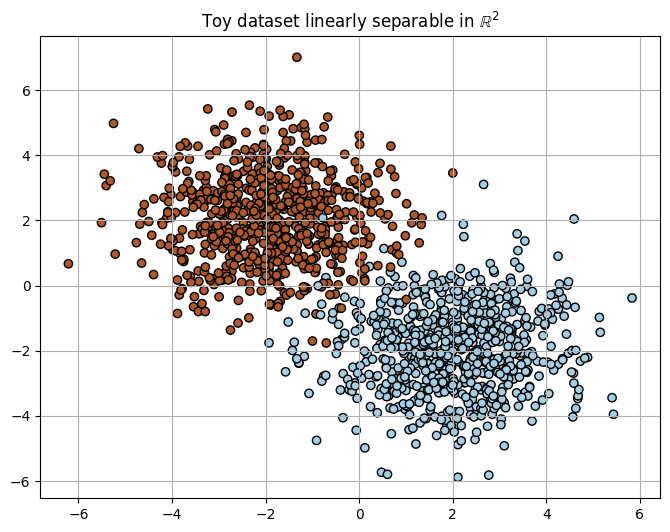

In [19]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-2,2),(2,-2)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

#### 1.2.2 Execution Time

Let's briefly examine the computation time to generate $N=5000$ samples for this simple dataset.

Recall that the goal of SGLD is to process the data in **batches**, but it still requires a **calibration** phase for the **hyperparameters** to ensure efficient convergence. During this calibration, we need to compute the **log-posterior** $\left(\log p(\beta_t | X, y)\right)_{t\geq 0}$ and the **coefficients** $(\alpha_t)_{t \geq 0}$ at each step. Calculating these quantities involves processing the entire dataset and computing the eigenvalue of a symmetric matrix in $\mathbb{R}^{|B| \times |B|}$, where $|B|$ is the batch size. These operations are costly. Therefore, we analyze the execution time **with and without** calculating these quantities.

In the case where the weights are stored at each step, they are simply ``floats`` stored in a fixed-size ``np.array``. The memory allocation is pre-allocated during initialization with `trackW = np.zeros(n_iter)`. Thus, it is not computationally expensive. It is unnecessary to focus on the computation time when storing the weights at each step.

It is also important to note that the **parameters** $a, \, b, \, \gamma$ for the step-sizes $(\epsilon_t)_{t \geq 0} = (a\cdot(b+t)^{-\gamma})_{t \geq 0}$ have been **calculated empirically** to ensure fast convergence without being too erratic. Specifically, the idea is to achieve relatively fast convergence during the optimization phase, while avoiding chaos. SGLD is, in a way, a symmetric random walk where the candidate is accepted at each step without calculating the acceptance probability. When the step-size $\epsilon_t$ is small, this doesn't cause any issues. However, when it is large, i.e., during the early iterations of the algorithm, it can be problematic, especially if the batch size is small, resulting in high variance for the stochastic gradient. This **calibration** of the **hyperparameters** is therefore **crucial** for maintaining **numerical stability** and **avoiding overflow** during the gradient computations.


In [20]:
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.random.rand(X.shape[1])
n_iter = 5000

# without computing log-posterior at each step
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing log-posterior at each step
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing alphas at each step
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:01<00:00, 2538.09it/s]


Done in 1.97 s.

Computing just the log-posterior at each step:


100%|██████████| 5000/5000 [00:02<00:00, 1907.86it/s]


Done in 2.63 s.

Computing just the alphas at each step:


100%|██████████| 5000/5000 [00:02<00:00, 2330.29it/s]


Done in 2.15 s.

Computing both the log-posterior and the alphas at each step:


100%|██████████| 5000/5000 [00:02<00:00, 1908.53it/s]


Done in 2.62 s.


In [21]:
a = .5
b = 30
gamma = .7
batch_size = 10
beta_0 = np.ones(X.shape[1])  # re-inject last sample in the next run
n_iter = 5000

# computing both alphas and log-posterior at each step
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:02<00:00, 1771.07it/s]

Done in 2.83 s.


### 1.2.3. Verifying the Optimization of the Log-Posterior and Sampling According to the Posterior

Let's verify that we are indeed optimizing the log-posterior and then sampling according to the posterior. We should observe two phases:

- A phase where the **log-posterior increases rapidly** (**optimization phase**: SGD),

- A phase where the algorithm **stabilizes in a high-probability region of the posterior** distribution and samples (**sampling phase**: Langevin).

Note!! It is important to clarify that the goal is not to stabilize in a single mode of the posterior (like the MAP) but to explore regions of high probability, especially in the case where the posterior is multi-modal.


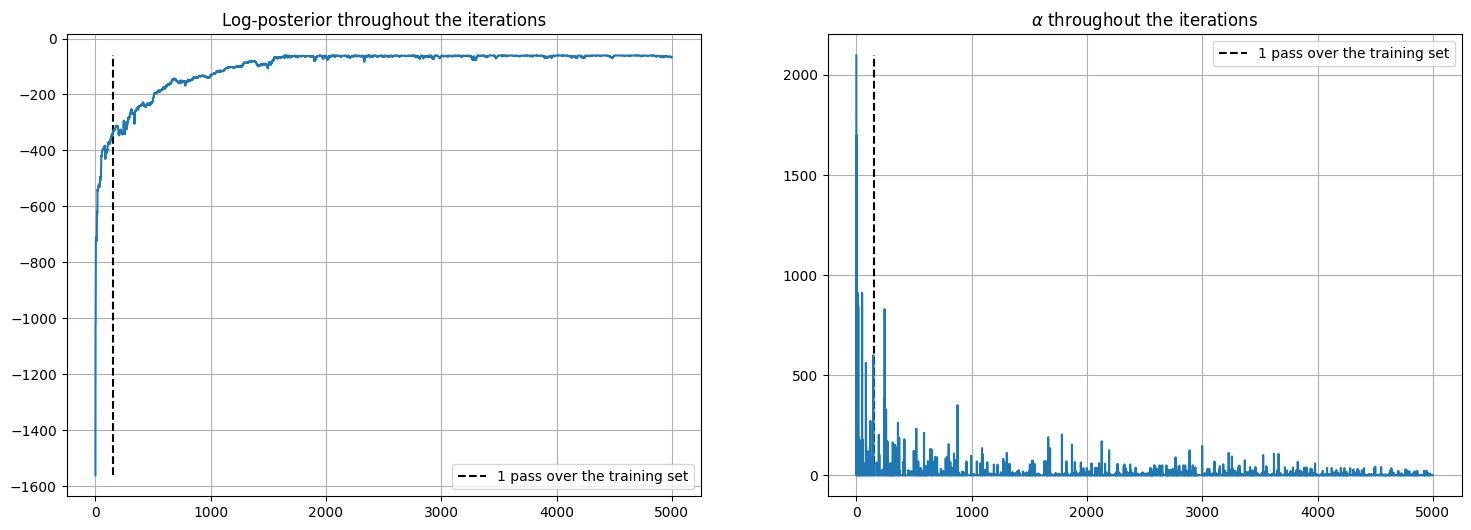

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot log-posterior
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

In [23]:
print(f"Averaged log-posterior over the last 1000 iterations: {round(trackL[-1000:].mean(), 2)}.")
print(f"Averaged alpha over the last 1000 iterations: {round(trackA[-1000:].mean(), 2)}.")

Averaged log-posterior over the last 1000 iterations: -62.28.
Averaged alpha over the last 1000 iterations: 1.59.


We observe that after **one pass** over the training set (batch_size=5, training_set_size=1000) and these values of $a$, $b$, and $\gamma$, the algorithm **stabilizes** more or less in the **sampling phase**.

Note that we calculated the coefficients $(\alpha_t)_{t \geq 0}$ **without using** a **conditioning matrix** $M$. However, these coefficients remain **very low**, with the empirical average over the last 1000 samples given by $\frac{1}{1000}\sum_{t=T-1000}^T\alpha_t \leq 0.1$ (slightly varying across executions). Additionally, we observe **some spikes**; these are related to the **variability** of the **stochastic gradient** and the fact that we **accept the new candidates systematically**. They correspond to steps where the stochastic gradient on the batch does not actually point toward a region of maximum probability, but the candidate generated is still accepted.


### 1.2.4. Model Predictions

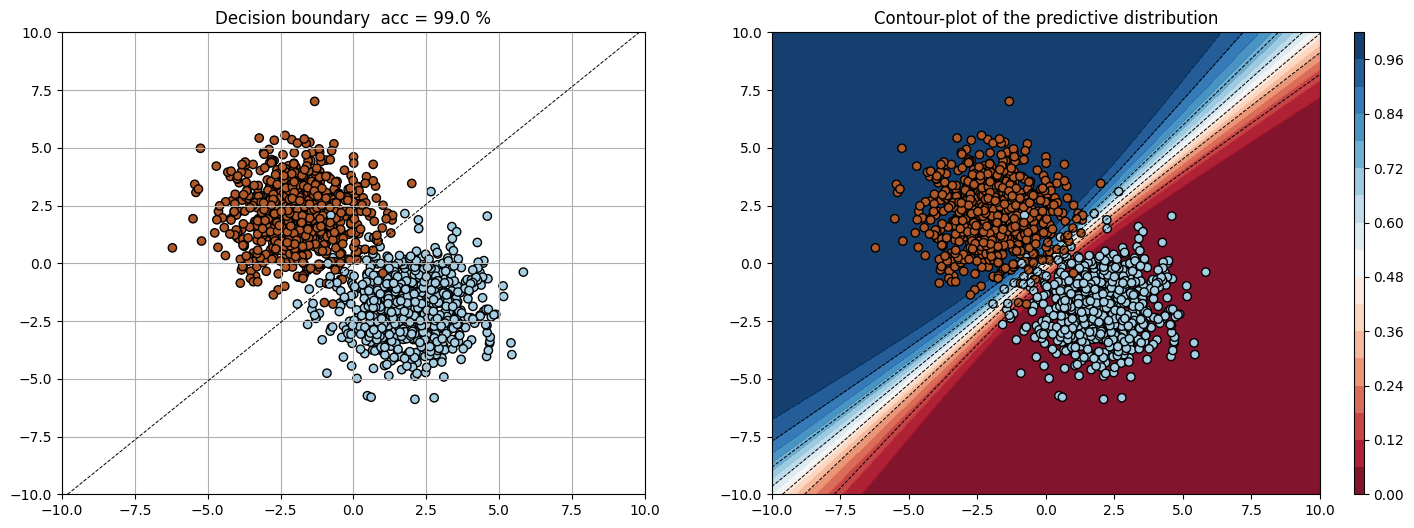

In [24]:
# approximation of the accuracy
beta = betas[-1]
acc = 100 * (np.sign(X @ beta) == y).mean()

# limits
xlim, ylim = (-4, 12), (-4, 12)

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=betas, burn_in=1000, weights=trackW)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[.5])
ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)
ax[0].set_title("Decision boundary "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()